<a href="https://colab.research.google.com/github/insancs/rock-paper-scissors-classifier/blob/main/rockpaperscissors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Profile

Nama : Chandra Arifin <br/>
Project : Submission 3 <br/>
Machine Learning (Intermediate)<br/>
Dataset : https://www.kaggle.com/datasets/andrewmvd/animal-faces


# Import Libraries

In [1]:
import numpy as np
import zipfile
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback

import matplotlib.pyplot as plt
from google.colab import files
from keras.preprocessing import image
import matplotlib.image as mpimg


%matplotlib inline

In [2]:
!pip install -q kaggle

# Variable Lokal

In [3]:
LOKASI_FILE = "/content/afhq/"
TRAINING_DIR = "/content/afhq/train/"
VALIDATION_DIR = "/content/afhq/val/"
numEpoch=40

# Import Dataset

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle (2).json': b'{"username":"chandraarifin","key":"6c4f515c25530bf3b2b9b22ea0a40eca"}'}

In [5]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [6]:
!kaggle datasets download -d andrewmvd/animal-faces

animal-faces.zip: Skipping, found more recently modified local copy (use --force to force download)


# Extract file

In [7]:
# Extract zip file
local_zip = '/content/animal-faces.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [8]:
# Check rps directory
os.listdir(LOKASI_FILE)

['train', 'val']

In [9]:
# Check rps-test-set direcroty
os.listdir(TRAINING_DIR)

['wild', 'dog', 'cat']

# Image Augmentation

In [34]:
# image augmentation
train_datagen = ImageDataGenerator(
    rescale = 1./255,
	  rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
)

validation_datagen = ImageDataGenerator(
    rescale = 1./255,
)

In [36]:
train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(512, 512),
    batch_size=32,
    class_mode='categorical',
    subset='training', # specify 'training' subset
)

validation_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(512, 512),
    batch_size=32,
    class_mode='categorical',
    subset='validation', # specify 'validation' subset
)

Found 11706 images belonging to 3 classes.
Found 2924 images belonging to 3 classes.


# Convolution Neural Network

In [12]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(512, 512, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Tampilkan summary model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 510, 510, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 255, 255, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 253, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 126, 126, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 64)      36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 62, 62, 64)        0

In [13]:
# Compile model
model.compile(loss = 'categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Create Callbacks

In [14]:
# Buat callback kostumisasi
class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.9):
          print("\nAkurasi telah mencapai >90%!")
          self.model.stop_training = True

    def on_train_begin(self, logs=None):
        print("Starting training")

    def on_train_end(self, logs=None):
        print("Training has been stopped")
        print('Accuracy = %2.2f%%' %(logs['accuracy']*100))

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1.5e-5
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=12,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True
)

In [15]:
history = model.fit(train_generator,
                    epochs=numEpoch,
                    steps_per_epoch=20,
                    validation_data = validation_generator,
                    verbose = 1,
                    validation_steps=3,
                    callbacks=[CustomCallback(), reduce_lr, early_stopping]
                    )

Starting training
Epoch 1/40
20/20 [==============================] - 57s 2s/step - loss: 1.5045 - accuracy: 0.3762 - val_loss: 1.1064 - val_accuracy: 0.2604 - lr: 0.0010
Epoch 2/40
20/20 [==============================] - 44s 2s/step - loss: 1.0981 - accuracy: 0.3469 - val_loss: 1.1091 - val_accuracy: 0.3542 - lr: 0.0010
Epoch 3/40
20/20 [==============================] - 42s 2s/step - loss: 1.1022 - accuracy: 0.3391 - val_loss: 1.0888 - val_accuracy: 0.3646 - lr: 0.0010
Epoch 4/40
20/20 [==============================] - 43s 2s/step - loss: 1.1098 - accuracy: 0.3594 - val_loss: 1.1008 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 5/40
20/20 [==============================] - 44s 2s/step - loss: 1.1151 - accuracy: 0.3594 - val_loss: 1.0953 - val_accuracy: 0.3646 - lr: 0.0010
Epoch 6/40
20/20 [==============================] - 43s 2s/step - loss: 1.0939 - accuracy: 0.3719 - val_loss: 1.0836 - val_accuracy: 0.3646 - lr: 0.0010
Epoch 7/40
20/20 [==============================] - 42s 2s/step 

# Plotting Loss and Accuracy

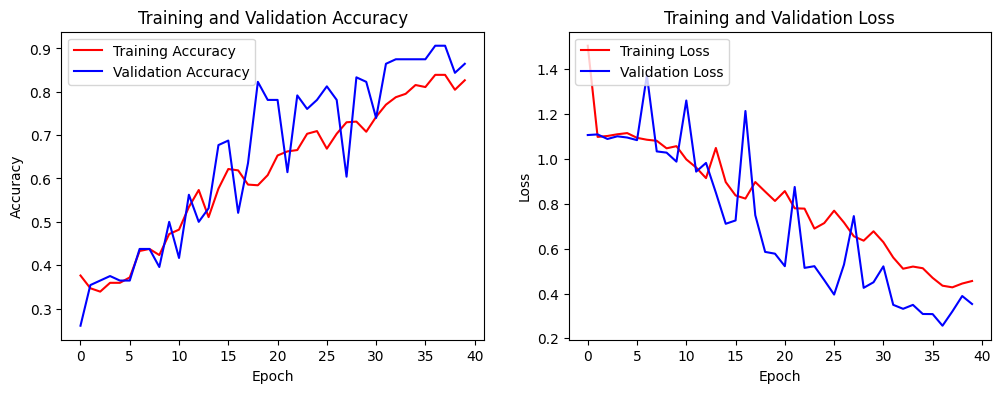

In [17]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12,4)

# Define accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Define loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Plotting accuracy
ax[0].plot(epochs, acc, 'r', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'b', label='Validation Accuracy')
ax[0].set_title('Training and Validation Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='upper left')

# Plotting loss
ax[1].plot(epochs, loss, 'r', label='Training Loss')
ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
ax[1].set_title('Training and Validation Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='upper left')

plt.show()

# Simpan model dalam bentuk formatTF-Lite

In [18]:
# # Save the model as a SavedModel
tf.saved_model.save(model, "/content/")

# # Convert the SavedModel to a TF-Lite model
converter = tf.lite.TFLiteConverter.from_saved_model("/content/")
tflite_model = converter.convert()

# # Save the TF-Lite model
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)